In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from net import Net
import random
import sys
import numpy as np

In [2]:
import sys
print(sys.executable)

/home/zliu/anaconda3/envs/myenv/bin/python


In [14]:
class MyDataset(Dataset):
    def __init__(self,rate):
        self.mnist = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))]))
        self.ran=[i for i in range(0,60000)]
        random.seed(42)
        torch.manual_seed(0)
        self.index=random.sample(self.ran,int(60000*rate))
        self.index_yes=list(set(range(60000))-set(self.index))
        #self.mnist.train_labels[self.index]=self.mnist.train_labels[self.index].random_(0,10)
        self.mnist=[self.mnist[i] for i in self.index_yes]
        
    def __getitem__(self, index):
        data, target = self.mnist[index]
        is_pure = index in self.index_yes
        is_corrupt = index in self.index
        return data, target, index, is_pure, is_corrupt

    def __len__(self):
        return len(self.mnist)

In [15]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, idx, is_pure, is_corrupt) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss_pure = F.nll_loss(output[is_pure],target[is_pure])
        loss_corrupt = F.nll_loss(output[is_corrupt],target[is_corrupt])
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item(), loss_pure.item(), loss_corrupt.item()

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    acc = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc=100. * correct / len(test_loader.dataset);
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
    return acc

In [16]:
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=600, metavar='N',
                        help='input batch size for training (default: 256)')
    parser.add_argument('--test-batch-size', type=int, default=4000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=100, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.005, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
     
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
#     train_loader = torch.utils.data.DataLoader(
#         x,
#         batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)
#     train_loader=x
    dataset = MyDataset(0.8)
    loader = DataLoader(dataset,
                        batch_size=600,
                        shuffle=True,
                        num_workers=10)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    acc=[]
    loss=[]
    loss_pure=[]
    loss_corrupt=[]
    for epoch in range(1, args.epochs + 1):
        l1,l2,l3=train(args, model, device, loader, optimizer, epoch)
        loss.append(l1)
        loss_pure.append(l2)
        loss_corrupt.append(l3)
        acc.append(test(args, model, device, test_loader))
    np.save("acc_p.npy",acc)
    np.save("loss_p.npy",loss)
    np.save("loss_pure_p.npy",loss_pure)
    np.save("loss_corrupt_p.npy",loss_corrupt)
    if (args.save_model):
        torch.save(model.state_dict(),"mnist_cnn_p.pt")

In [17]:
sys.argv = ['-f']
main()

Train Epoch: 1 [0/12000 (0%)]	Loss: 2.313942

Test set: Average loss: 2.0511, Accuracy: 6513/10000 (65%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 2.059071

Test set: Average loss: 0.9001, Accuracy: 8108/10000 (81%)

Train Epoch: 3 [0/12000 (0%)]	Loss: 0.972176

Test set: Average loss: 0.4070, Accuracy: 8751/10000 (88%)

Train Epoch: 4 [0/12000 (0%)]	Loss: 0.431098

Test set: Average loss: 0.3431, Accuracy: 8960/10000 (90%)

Train Epoch: 5 [0/12000 (0%)]	Loss: 0.330689

Test set: Average loss: 0.2687, Accuracy: 9182/10000 (92%)

Train Epoch: 6 [0/12000 (0%)]	Loss: 0.312739

Test set: Average loss: 0.2489, Accuracy: 9223/10000 (92%)

Train Epoch: 7 [0/12000 (0%)]	Loss: 0.225494

Test set: Average loss: 0.2216, Accuracy: 9318/10000 (93%)

Train Epoch: 8 [0/12000 (0%)]	Loss: 0.219722

Test set: Average loss: 0.1921, Accuracy: 9426/10000 (94%)

Train Epoch: 9 [0/12000 (0%)]	Loss: 0.194226

Test set: Average loss: 0.1753, Accuracy: 9474/10000 (95%)

Train Epoch: 10 [0/12000 (0%)]	Loss: 0.151409


Train Epoch: 78 [0/12000 (0%)]	Loss: 0.009719

Test set: Average loss: 0.0536, Accuracy: 9826/10000 (98%)

Train Epoch: 79 [0/12000 (0%)]	Loss: 0.007265

Test set: Average loss: 0.0556, Accuracy: 9825/10000 (98%)

Train Epoch: 80 [0/12000 (0%)]	Loss: 0.006125

Test set: Average loss: 0.0558, Accuracy: 9831/10000 (98%)

Train Epoch: 81 [0/12000 (0%)]	Loss: 0.009539

Test set: Average loss: 0.0565, Accuracy: 9828/10000 (98%)

Train Epoch: 82 [0/12000 (0%)]	Loss: 0.009580

Test set: Average loss: 0.0553, Accuracy: 9828/10000 (98%)

Train Epoch: 83 [0/12000 (0%)]	Loss: 0.005448

Test set: Average loss: 0.0537, Accuracy: 9829/10000 (98%)

Train Epoch: 84 [0/12000 (0%)]	Loss: 0.004716

Test set: Average loss: 0.0537, Accuracy: 9826/10000 (98%)

Train Epoch: 85 [0/12000 (0%)]	Loss: 0.004297

Test set: Average loss: 0.0548, Accuracy: 9827/10000 (98%)

Train Epoch: 86 [0/12000 (0%)]	Loss: 0.007299

Test set: Average loss: 0.0562, Accuracy: 9830/10000 (98%)

Train Epoch: 87 [0/12000 (0%)]	Loss: 

In [29]:
acc=np.load("acc.npy")
x_axis=np.arange(100)
loss=np.load("loss.npy")
loss

array([tensor(2.2645, device='cuda:0', requires_grad=True),
       tensor(2.2455, device='cuda:0', requires_grad=True),
       tensor(2.2085, device='cuda:0', requires_grad=True),
       tensor(2.2053, device='cuda:0', requires_grad=True),
       tensor(2.2169, device='cuda:0', requires_grad=True),
       tensor(2.1952, device='cuda:0', requires_grad=True),
       tensor(2.1743, device='cuda:0', requires_grad=True),
       tensor(2.2074, device='cuda:0', requires_grad=True),
       tensor(2.2063, device='cuda:0', requires_grad=True),
       tensor(2.1933, device='cuda:0', requires_grad=True),
       tensor(2.1780, device='cuda:0', requires_grad=True),
       tensor(2.1890, device='cuda:0', requires_grad=True),
       tensor(2.1784, device='cuda:0', requires_grad=True),
       tensor(2.1452, device='cuda:0', requires_grad=True),
       tensor(2.2098, device='cuda:0', requires_grad=True),
       tensor(2.1502, device='cuda:0', requires_grad=True),
       tensor(2.2026, device='cuda:0', r

In [30]:
import matplotlib.pyplot as plt

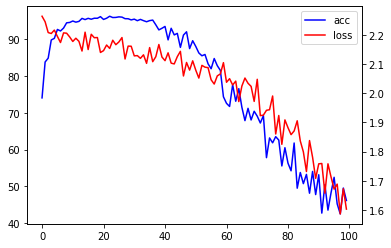

In [32]:
# fig,left_axis=plt.subplots()
# right_axis = left_axis.twinx()

# p1, = left_axis.plot(x_axis,p,color='blue',label="acc")
# p2, = right_axis.plot(x_axis,loss,color='red',label="loss")
# plt.title("result")
# plt.legend(loc="best")
fig = plt.figure()
ax = fig.add_subplot(111)
f1=ax.plot(x_axis,acc,color='blue',label="acc")
ax2 = ax.twinx()
f2=ax2.plot(x_axis,loss,color='red',label="loss")
f=f1+f2
labs = [l.get_label() for l in f]
ax.legend(f, labs, loc=0)


In [10]:
def main_corrupt_set():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=600, metavar='N',
                        help='input batch size for training (default: 256)')
    parser.add_argument('--test-batch-size', type=int, default=4000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=100, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.005, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
     
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        x_corrupt,
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)
#     train_loader=x
    
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    acc=[]
    loss=[]
    for epoch in range(1, args.epochs + 1):
        loss.append(train(args, model, device, train_loader, optimizer, epoch))
        acc.append(test(args, model, device, test_loader))
    np.save("acc_corrupt.npy",acc)
    np.save("loss_corrupt.npy",loss)
    if (args.save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

In [11]:
sys.argv = ['-f']
main_corrupt_set()

NameError: name 'x_corrupt' is not defined

In [31]:
def main_pure_set():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=600, metavar='N',
                        help='input batch size for training (default: 256)')
    parser.add_argument('--test-batch-size', type=int, default=4000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=100, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.005, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
     
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        x_pure,
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)
#     train_loader=x

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    acc=[]
    loss=[]
    for epoch in range(1, args.epochs + 1):
        loss.append(train(args, model, device, train_loader, optimizer, epoch))
        acc.append(test(args, model, device, test_loader))
    np.save("acc_pure.npy",acc)
    np.save("loss_pure.npy",loss)
    if (args.save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

In [32]:
sys.argv = ['-f']
main_pure_set()

Train Epoch: 1 [0/12000 (0%)]	Loss: 2.303364

Test set: Average loss: 2.0628, Accuracy: 5873/10000 (59%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 2.055946

Test set: Average loss: 0.9533, Accuracy: 7633/10000 (76%)

Train Epoch: 3 [0/12000 (0%)]	Loss: 0.952204

Test set: Average loss: 0.4601, Accuracy: 8569/10000 (86%)

Train Epoch: 4 [0/12000 (0%)]	Loss: 0.511371

Test set: Average loss: 0.3522, Accuracy: 8895/10000 (89%)

Train Epoch: 5 [0/12000 (0%)]	Loss: 0.374803

Test set: Average loss: 0.2909, Accuracy: 9141/10000 (91%)

Train Epoch: 6 [0/12000 (0%)]	Loss: 0.297305

Test set: Average loss: 0.2577, Accuracy: 9228/10000 (92%)

Train Epoch: 7 [0/12000 (0%)]	Loss: 0.254769

Test set: Average loss: 0.2295, Accuracy: 9326/10000 (93%)

Train Epoch: 8 [0/12000 (0%)]	Loss: 0.277708

Test set: Average loss: 0.2042, Accuracy: 9401/10000 (94%)

Train Epoch: 9 [0/12000 (0%)]	Loss: 0.232820

Test set: Average loss: 0.1930, Accuracy: 9442/10000 (94%)

Train Epoch: 10 [0/12000 (0%)]	Loss: 0.190357


Train Epoch: 78 [0/12000 (0%)]	Loss: 0.012835

Test set: Average loss: 0.0564, Accuracy: 9838/10000 (98%)

Train Epoch: 79 [0/12000 (0%)]	Loss: 0.006972

Test set: Average loss: 0.0554, Accuracy: 9828/10000 (98%)

Train Epoch: 80 [0/12000 (0%)]	Loss: 0.010158

Test set: Average loss: 0.0559, Accuracy: 9832/10000 (98%)

Train Epoch: 81 [0/12000 (0%)]	Loss: 0.009549

Test set: Average loss: 0.0557, Accuracy: 9829/10000 (98%)

Train Epoch: 82 [0/12000 (0%)]	Loss: 0.007927

Test set: Average loss: 0.0539, Accuracy: 9828/10000 (98%)

Train Epoch: 83 [0/12000 (0%)]	Loss: 0.009585

Test set: Average loss: 0.0552, Accuracy: 9829/10000 (98%)

Train Epoch: 84 [0/12000 (0%)]	Loss: 0.011731

Test set: Average loss: 0.0544, Accuracy: 9831/10000 (98%)

Train Epoch: 85 [0/12000 (0%)]	Loss: 0.008095

Test set: Average loss: 0.0545, Accuracy: 9822/10000 (98%)

Train Epoch: 86 [0/12000 (0%)]	Loss: 0.007812

Test set: Average loss: 0.0545, Accuracy: 9832/10000 (98%)

Train Epoch: 87 [0/12000 (0%)]	Loss: 

In [33]:
acc=np.load("acc.npy")
x_axis=np.arange(100)
loss=np.load("loss.npy")
loss_corrupt=np.load("loss_corrupt.npy")
loss_pure=np.load("loss_pure.npy")

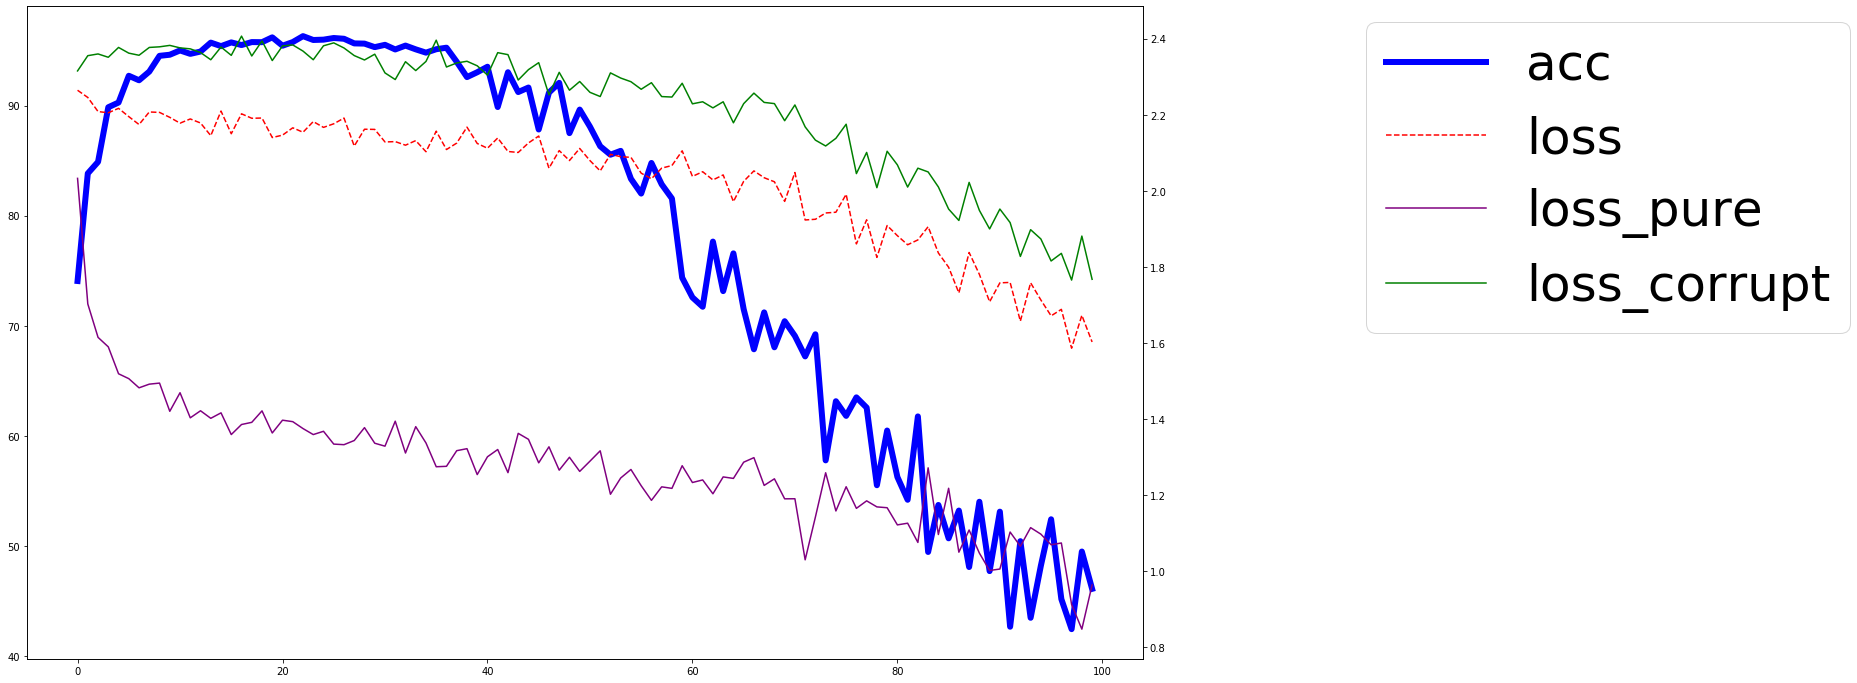

In [34]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
f1=ax.plot(x_axis,acc,color='blue',label="acc",lw=6)
ax2 = ax.twinx()
f2=ax2.plot(x_axis,loss,color='red',label="loss",ls='dashed')
f3=ax2.plot(x_axis,loss_pure,color='purple',label="loss_pure")
f4=ax2.plot(x_axis,loss_corrupt,color='green',label="loss_corrupt")
f=f1+f2+f3+f4
labs = [l.get_label() for l in f]
ax.legend(f, labs, loc=[1.2, 0.5],prop={'size': 50})